# Efficient background event generation

## Introduction and machinery

Background simulation is a general problem for particle detectors. The experiment is generally designed to reject background events, but some do sneak through. Since these are rare by construction, an unbiased simulation of the background will waste most of its time generating events that are almost guaranteed to be rejected, and thus not affect the final background estimate at all. Ideally, you would like to simulate _only_ those events that will actually be selected, and then weight those events to reflect their true frequency. While this is impossible to do exactly for all but the most trivial detector responses, approximations can exist for realstic detector responses.

Here we examine a toy model that mimics some of the features of the background of penetrating atmospheric muons to neutrino events in a sparse, natural-medium Cherenkov detector like e.g. IceCube. One easy way to separate neutrinos from penetrating muons is to use the outermost layer of sensors as an active veto: neutrino events will start inside the volume, while muons will usually be detected at the border. A penetrating muon event can be misclassified as a neutrino event if the muon is too dim to be detected at the border, but experiences a catastrophic energy loss deep in the instrumented volume. To approximate this scenario, we set up a simple 2D sensor array on a (slightly irregular) hexagonal grid.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from utils import Geometry, simulate_events, classify_events

# radius of a circle that contains all the grid points
radius = 2.3
geometry = Geometry.create(spacing=1, radius=radius, jitter=0.1)

Now we can generate some events in this geometry. For simplicity we draw a direction for our muon uniformly in $[0,2\pi)$ and an impact parameter uniformly in $[-r,r)$, and pick a position for its largest stochastic energy loss. The amplitude of that energy loss is proportional to the parent muon energy on average. Given the energy and trajectory of the muon and the energy and position of the stochastic energy loss, we can draw the counts that our sensors would register. In the display below, the line and star mark the muon and its energy loss, while the area of the blue and yellow circles are proportional to the counts in the veto and fiducial regions, respectively. An event is considered to "trigger" if it has >= 20 counts in the fiducial region, and to be vetoed if it has at least one count in the veto region.

You can run the cell below several times to see what events look like.

The events we're interested in are those with a loss in the fiducial region that trigger, but pass the veto.

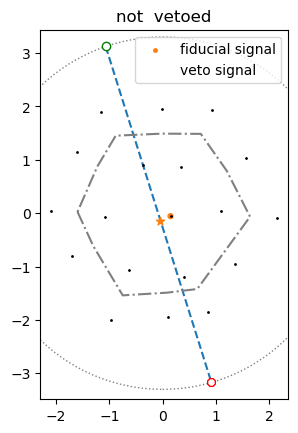

In [2]:
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

ax = plt.gca()
ax.scatter(*geometry.xy.T, color="k", s=1, zorder=10)
ax.add_artist(Circle((0, 0), radius + 1, facecolor="None", edgecolor="grey", ls=":"))

plt.plot(*geometry.fiducial_boundary.T, color="grey", ls="-.")

angle = np.random.uniform(0, 2 * np.pi, size=100)
impact = np.random.uniform(-radius + 1, radius - 1, size=100)

enter, exit, loss_position, fiducial_signal, veto_signal = simulate_events(
    geometry, radius + 1, angle, impact, np.ones(100) * 3
)
in_volume, triggered, vetoed = classify_events(
    geometry, loss_position, fiducial_signal, veto_signal
)

idx = np.where(in_volume & triggered)[0][0]
mask = slice(idx, idx + 1)

for start, end in zip(enter[mask], exit[mask]):
    ax.add_artist(Line2D([start[0], end[0]], [start[1], end[1]], ls="--", zorder=0))

ax.scatter(*enter[mask].T, marker="o", edgecolor="g", facecolor="w")
ax.scatter(*exit[mask].T, marker="8", edgecolor="r", facecolor="w")
ax.scatter(loss_position[mask, 0], loss_position[mask, 1], marker="*", color="C1")
ax.scatter(
    *geometry.fiducial_xy.T,
    s=np.power(fiducial_signal[mask], 1 / 2),
    facecolor="C1",
    label="fiducial signal",
)
ax.scatter(
    *geometry.veto_xy.T,
    s=np.power(veto_signal[mask], 1 / 2),
    facecolor="C0",
    label="veto signal",
)
ax.set_title(f'{"not " if not vetoed[mask] else ""} vetoed')

ax.set_aspect("equal")
ax.legend()


## Generating an event sample

In [3]:
size = 1_000_000

# sample uniformly in direction
angle = np.random.uniform(0, 2 * np.pi, size=size)
# sample uniformly in impact parameter
impact = np.random.uniform(-radius - 1, radius + 1, size=size)
# particle "energy"
log_energy = np.random.uniform(2, 5, size=size)

enter, exit, loss_position, fiducial_signal, veto_signal = simulate_events(
    geometry, radius + 1, angle, impact, log_energy
)
in_volume, triggered, vetoed = classify_events(
    geometry, loss_position, fiducial_signal, veto_signal
)
unvetoed = triggered & ~vetoed

df = pd.DataFrame(
    {
        "angle": angle,
        "impact": impact,
        "log_energy": log_energy,
        "in_volume": in_volume,
        "triggered": triggered,
        "vetoed": vetoed,
    }
)

df[unvetoed].to_csv("background_events.csv", index=False)
# also dump the geometry e.g. for later evaluation in a different notebook
geometry.dump("geometry.npz")


## Features of the background distribution

First look at the energy distribution. The first thing to notice is that the efficiency for events passing the veto is quite low. While the "simulation" in this toy example is trivial, real detector simulations are a significant bottleneck. Second, the efficiency depends strongly on energy.

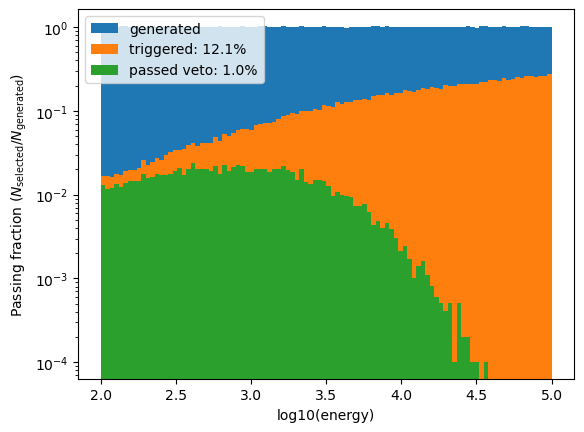

In [6]:
bins = np.linspace(2, 5, 101)
weight = len(bins) / len(df)
df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df)) * weight, label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight, label=f'triggered: {triggered.sum()/len(df)*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight, label=f'passed veto: {unvetoed.sum()/len(df)*100:.1f}%')

plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.legend()

Geometry also plays a large part in the passing rate: there are regions in the angle/impact plane where events are more likely to pass than others. Try making this plot with a higher energy threshold, and notice how they change.

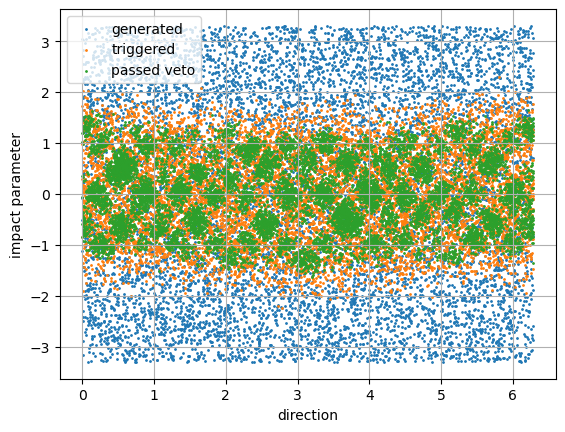

In [5]:
sel = slice(10000)
plt.scatter(angle[sel], impact[sel], s=1, label='generated')

sel = triggered
plt.scatter(angle[sel][:10000], impact[sel][:10000], s=1, label='triggered')

sel = unvetoed
plt.scatter(angle[sel][:10000], impact[sel][:10000], s=1, label='passed veto')

plt.grid()
plt.xlabel("direction")
plt.ylabel("impact parameter")
plt.legend()


## Exercise

1. Generate events (angle, impact, log_energy) that are likely to pass the veto criterion, i.e. when you evaluate them with `simulate_events` and `classify_events`, the fraction that are `triggered & ~vetoed` should be $> 0.01$. It does not matter what method you use to do this, as long as you can explain why you chose it.
2. Calculate the probability of obtaining each of your biased samples from the uniform sampler in this notebook. Can you reproduce the passing-rate histogram above using your biased events? If not, what other information would you need to calculate the unbiased passing fraction?